# Оптимизация функций

## Методы, которые нужно реализовать

1. Метод деформируемого многранника
2. Градиентный метод
3. Метод сопряженных градиентов
4. Ньютоновский метод

$ f_1 (x) = 100 (x_2 - x_1^2)^2  +  5 (1 - x_1)^2 $

$ f_2 (x) = (x_1^2 + x_2 - 11)^2 + (x_1 + x_2^2 - 7)^2 $

## Визуализируем функции

In [1]:
import random
import math
import itertools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f1(x1, x2):    
    it1 = 100 * (x2 - x1**2)**2
    it2 = 5 * (1 - x1)**2
    return it1 + it2

In [3]:
def f2(x1, x2):
    it1 = (x1**2 + x2 - 11)**2
    it2 = (x1 + x2**2 - 7)**2
    return it1 + it2

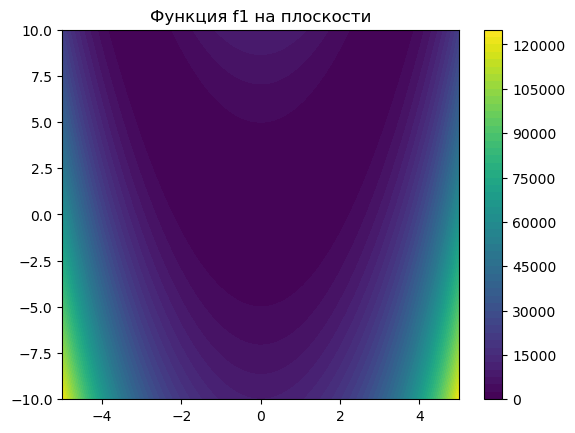

In [4]:
x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-10, 10, 1000)

X, Y = np.meshgrid(x1, x2)
Z = f1(X, Y)

plt.contourf(X, Y, Z, levels=50)
plt.title('Функция f1 на плоскости')
plt.colorbar()
None

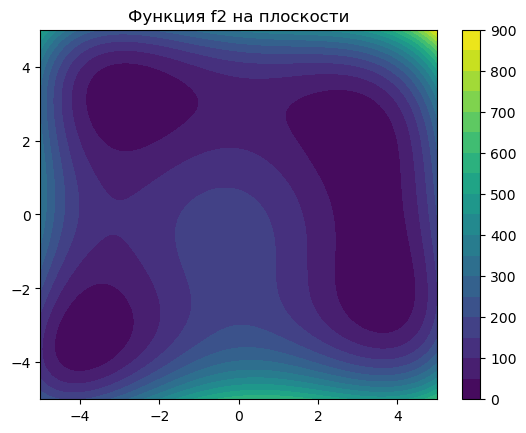

In [5]:
x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)

X, Y = np.meshgrid(x1, x2)
Z = f2(X, Y)

plt.contourf(X, Y, Z, levels=20)
plt.title('Функция f2 на плоскости')
plt.colorbar()
None

## 1. Метод деформируемого многранника

**Работа метода:**

1. Отражение (Reflection): Создается отраженная точка относительно центроида вершин (получается путем отражения худшей вершины относительно центроида). Если отраженная точка улучшает многогранник, она заменяет худшую вершину.
2. Расширение (Expansion): Если отраженная точка продолжает улучшаться, выполняется расширение, создавая новую точку дальше от отраженной точки. Если эта точка также улучшает многогранник, она заменяет худшую вершину.
3. Сжатие (Contraction): Если отраженная точка хуже лучшей, но лучше худшей вершины, то выполняется сжатие. Создается точка ближе к центроиду. Если сжатая точка улучшает многогранник, она заменяет худшую вершину.
4. Уменьшение размера многогранника (Reduction): Если ни одно из вышеперечисленных действий не приводит к улучшению, то многогранник уменьшается в размерах. Все вершины, кроме лучшей, приближаются к лучшей вершине.

In [6]:
def nelder_mead_optimize(f, initial_simplex, eps=1e-6, max_iters=100):
    simplexes = [initial_simplex]
    
    n = len(initial_simplex[0])
    simplex = initial_simplex
    
    iterations = 0

    def sort_key(vertex):
        return f(*vertex)

    for i in range(max_iters):
        simplex = sorted(simplex, key=sort_key)
        best, second_best, worst = simplex
        
        centroid = np.mean(simplex, axis=0)

        if np.linalg.norm(worst - best) < eps:
            return best, simplexes, iterations

        reflected = centroid + (centroid - worst)

        if f(*best) <= f(*reflected) < f(*second_best):
            simplex[2] = reflected
        elif f(*reflected) < f(*best):
            expanded = centroid + 2 * (reflected - centroid)
            
            if f(*expanded) < f(*reflected):
                simplex[2] = expanded
            else:
                simplex[2] = reflected
        else:
            contracted = centroid + 0.5 * (worst - centroid)
            
            if f(*contracted) < f(*worst):
                simplex[2] = contracted
            else:
                for i in range(1, n+1):
                    simplex[i] = best + 0.5 * (simplex[i] - best)
                
        simplexes.append(simplex)
        iterations += 1

    return min(simplex, key=sort_key), np.array(simplexes), iterations

Кол-во итераций (функция f1) (min, mean, max): (25, 46.0, 62) 
Кол-во итераций (функция f2) (min, mean, max): (25, 40.6, 66) 
Wall time: 840 ms


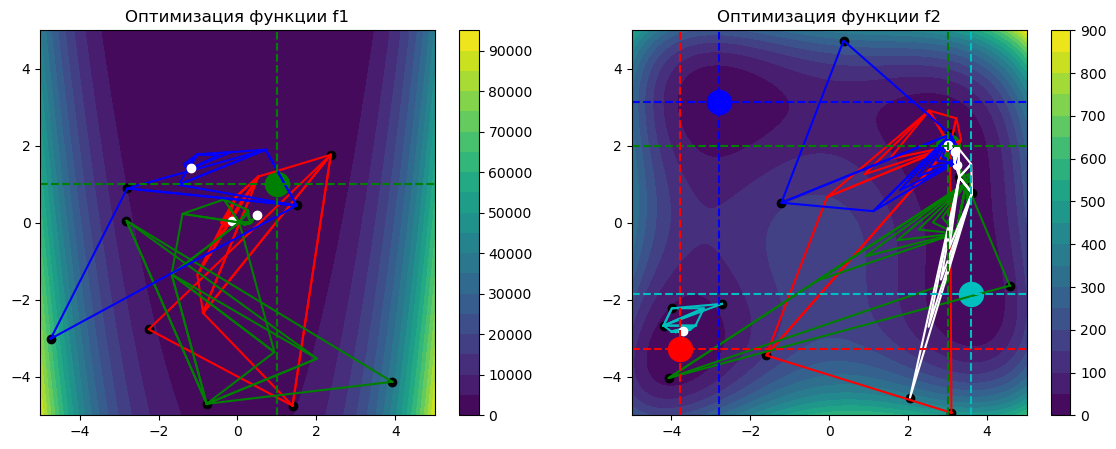

In [7]:
%%time

random.seed(42)

N_maxs = [100, 100]
max_counts = [3, 5]
eps = 1e-4
mins = [
    [(1, 1)],
    [
        (3, 2),
        (-3.779, -3.283),
        (-2.805, 3.131),
        (3.584, -1.848),
    ],
]
verbose = True

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
colors = ['r', 'g', 'b', 'w', 'c', 'm', 'y', 'k', 'silver', 'orange', 'cyan', 'yellow', 'pink']

for i, ax, f in zip(range(2), axs, [f1, f2]):
    x1 = np.linspace(-5, 5, 1000)
    x2 = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x1, x2)
    Z = f(X, Y)

    pcm = ax.contourf(X, Y, Z, levels=20)
    fig.colorbar(pcm, ax=ax)
    ax.set_title(f'Оптимизация функции f{i+1}')
    
    iterations_array = []

    # function optimization (start from different points)
    for col, _ in zip(colors, range(max_counts[i])):
        initial_simplex = np.array([(random.random() * 10 - 5, random.random() * 10 - 5) for _ in range(3)])

        x_opt, simplexes, iterations = nelder_mead_optimize(f, initial_simplex, eps, max_iters=N_maxs[i])
        iterations_array.append(iterations)
        
        for j, s in enumerate(simplexes):
            triangle = np.vstack((s, [s[0]]))            
            ax.plot(triangle[:, 0], triangle[:, 1], col)
        
        ax.plot(*x_opt, f'wo')
        ax.scatter(initial_simplex[:, 0], initial_simplex[:, 1], c=f'black')
    
    if verbose:
        for col, mp in zip(['g', 'r', 'b', 'c', 'm', 'y', 'k'], mins[i]):
            ax.axvline(x=mp[0], color=col, linestyle='--')
            ax.axhline(y=mp[1], color=col, linestyle='--')
            ax.scatter(*mp, c=col, s=300)
            
        min_it = min(iterations_array)
        mean_it = np.mean(iterations_array)
        max_it = max(iterations_array)
        print(f'Кол-во итераций (функция f{i+1}) (min, mean, max): {min_it, mean_it, max_it} ')

axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
None

## 2. Градиентный метод

In [8]:
def euclidian_norm(x1, x2):
    return (x1**2 + x2**2)**0.5

In [9]:
def grad_f(f, x1, x2, eps=1e-3, max_norm=25):
    g1 = (f(x1 + eps, x2) - f(x1, x2)) / eps
    g2 = (f(x1, x2 + eps) - f(x1, x2)) / eps
    
    if max_norm:
        norm = euclidian_norm(g1, g2)
        
        if norm > max_norm:
            k = max_norm / norm
            g1 *= k
            g2 *= k
        
    return g1, g2

In [10]:
def grad_optimize(f, x10, x20, alpha=0.01, x_eps=1e-4, grad_eps=1e-4, deriv_eps=1e-3, max_iters=100):
    X1, X2 = [x10], [x20]
    x1, x2 = x10, x20
    iterations = 0
    
    for i in range(max_iters):
        g1, g2 = grad_f(f, x1, x2, deriv_eps)
        
        if euclidian_norm(g1, g2) < grad_eps:
            break
        
        x1 -= alpha*g1
        x2 -= alpha*g2
        
        X1.append(x1)
        X2.append(x2)
        
        iterations += 1
        
        if ((x1 - X1[-2])**2 + (x2 - X2[-2])**2) < x_eps**2:
            break
            
    return (x1, x2), (X1, X2), iterations

Кол-во итераций (функция f1) (min, mean, max): (1000, 1000.0, 1000) 
Кол-во итераций (функция f2) (min, mean, max): (4, 35.535, 100) 
Wall time: 8.23 s


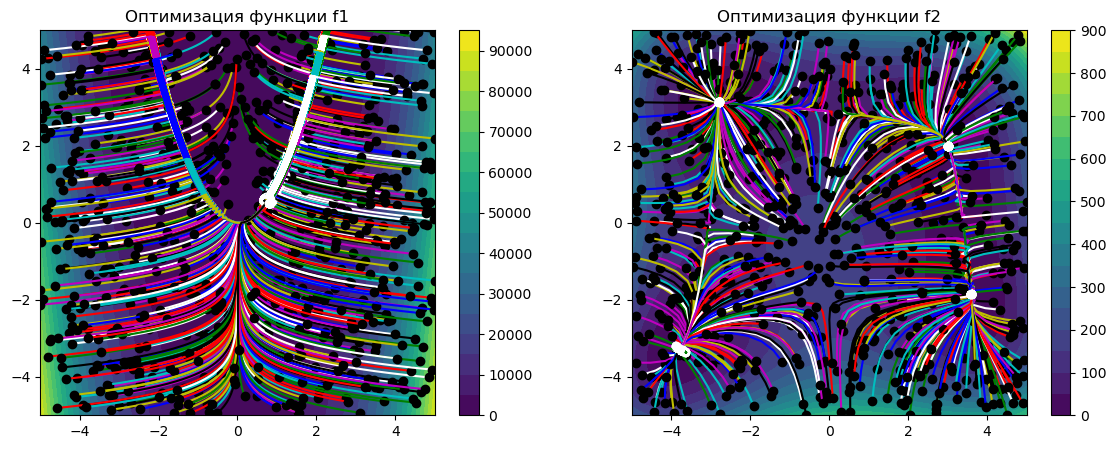

In [11]:
%%time

random.seed(42)

alphas = [0.005, 0.015]
N_maxs = [1000, 100]
eps = 1e-4
verbose = True

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i, ax, f in zip(range(2), axs, [f1, f2]):
    x1 = np.linspace(-5, 5, 1000)
    x2 = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x1, x2)
    Z = f(X, Y)

    pcm = ax.contourf(X, Y, Z, levels=20)
    fig.colorbar(pcm, ax=ax)
    ax.set_title(f'Оптимизация функции f{i+1}')
    
    iterations_array = []

    # function optimization (start from different points)
    for col in 100 * ['r', 'g', 'b', 'w', 'c', 'm', 'y', 'k']:
        x0 = (random.random() * 10 - 5, random.random() * 10 - 5)

        x_opt, x_trace, iterations = grad_optimize(f, *x0, alphas[i], eps, max_iters=N_maxs[i])
        iterations_array.append(iterations)
        
        ax.plot(*x_trace, f'{col}-')
        ax.plot(*x0, f'ko')
        ax.plot(*x_opt, f'wo')
    
    if verbose:
        min_it = min(iterations_array)
        mean_it = np.mean(iterations_array)
        max_it = max(iterations_array)
        print(f'Кол-во итераций (функция f{i+1}) (min, mean, max): {min_it, mean_it, max_it} ')

axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
None

## 3. Метод сопряженных градиентов

In [12]:
def backtracking_line_search(f, x1, x2, g1, g2, alpha=0.1, beta=0.7):
    t = 1.0
    
    while f(x1 - t * g1, x2 - t * g2) > f(x1, x2) - alpha * t * (g1**2 + g2**2):
        t *= beta

    return t

In [13]:
def conjugate_grad_optimize(f, x10, x20, alpha=0.5, beta=0.7, x_eps=1e-4, grad_eps=1e-4, deriv_eps=1e-3, super_alpha=0.5, max_iters=100):
    X1, X2 = [x10], [x20]
    x1, x2 = x10, x20
    iterations = 0
    
    for i in range(max_iters):
        g1, g2 = grad_f(f, x1, x2, deriv_eps)
        
        if euclidian_norm(g1, g2) < grad_eps:
            break
        
        b_alpha = backtracking_line_search(f, x1, x2, g1, g2, alpha, beta)
        
        x1 -= super_alpha * b_alpha * g1
        x2 -= super_alpha * b_alpha * g2
        
        X1.append(x1)
        X2.append(x2)
        
        iterations += 1
        
        if ((x1 - X1[-2])**2 + (x2 - X2[-2])**2) < x_eps**2:
            break
            
    return (x1, x2), (X1, X2), iterations

Кол-во итераций (функция f1) (min, mean, max): (41, 83.75, 117) 
Кол-во итераций (функция f2) (min, mean, max): (32, 50.125, 79) 
Wall time: 802 ms


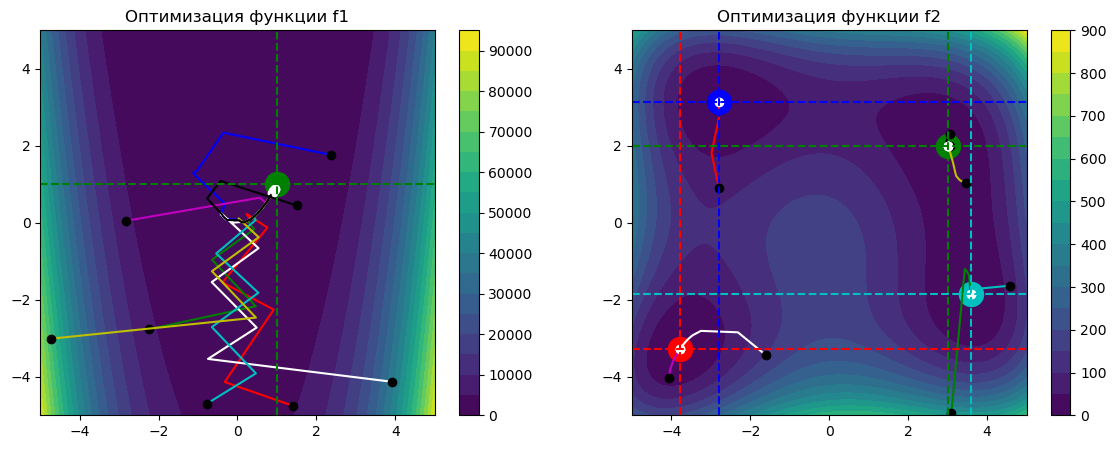

In [14]:
%%time

random.seed(42)

alphas = [0.8, 0.8]
betas = [0.9, 0.25]
super_alpha = 0.6
N_maxs = [1000, 100]
eps = 1e-4
mins = [
    [(1, 1)],
    [
        (3, 2),
        (-3.779, -3.283),
        (-2.805, 3.131),
        (3.584, -1.848),
    ],
]
verbose = True

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i, ax, f in zip(range(2), axs, [f1, f2]):
    x1 = np.linspace(-5, 5, 1000)
    x2 = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x1, x2)
    Z = f(X, Y)

    pcm = ax.contourf(X, Y, Z, levels=20)
    fig.colorbar(pcm, ax=ax)
    ax.set_title(f'Оптимизация функции f{i+1}')
    
    iterations_array = []

    # function optimization (start from different points)
    for col in ['r', 'g', 'b', 'w', 'c', 'm', 'y', 'k']:
        x0 = (random.random() * 10 - 5, random.random() * 10 - 5)

        x_opt, x_trace, iterations = conjugate_grad_optimize(f, *x0, alphas[i], betas[i], eps, super_alpha=super_alpha, max_iters=N_maxs[i])
        iterations_array.append(iterations)
        
        ax.plot(*x_trace, f'{col}-')
        ax.plot(*x0, f'ko')
        ax.plot(*x_opt, f'wo')
    
    
    if verbose:
        for col, mp in zip(['g', 'r', 'b', 'c', 'm', 'y', 'k'], mins[i]):
            ax.axvline(x=mp[0], color=col, linestyle='--')
            ax.axhline(y=mp[1], color=col, linestyle='--')
            ax.scatter(*mp, c=col, s=300)

        min_it = min(iterations_array)
        mean_it = np.mean(iterations_array)
        max_it = max(iterations_array)
        print(f'Кол-во итераций (функция f{i+1}) (min, mean, max): {min_it, mean_it, max_it} ')

axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
None

## 4. Ньютоновский метод

In [15]:
def hessian_f1(x1, x2):
    d2f1_dx1dx1 = 1200 * x1**2 - 400 * x2 + 2
    d2f1_dx1dx2 = -400 * x1
    d2f1_dx2dx1 = -400 * x1
    d2f1_dx2dx2 = 200
    return np.array([[d2f1_dx1dx1, d2f1_dx1dx2], [d2f1_dx2dx1, d2f1_dx2dx2]])


def hessian_f2(x1, x2):
    ddf1x1 = 12 * x1**2 + 4 * x2 - 42
    ddf1x2 = 4 * x1 + 4 * x2
    ddf2x1 = 4 * x1 + 4 * x2
    ddf2x2 = 4 * x1 + 12 * x2**2 - 26
    return np.array([[ddf1x1, ddf1x2], [ddf2x1, ddf2x2]])

In [16]:
def newton_optimize(f, hessian_f, x10, x20, x_eps=1e-4, grad_eps=1e-4, deriv_eps=1e-3, max_iters=100):
    X1, X2 = [x10], [x20]
    x1, x2 = x10, x20
    good = True
    iterations = 0
    
    for i in range(max_iters):
        g = np.array(grad_f(f, x1, x2, deriv_eps))
        hes = hessian_f(x1, x2)
        
        if np.linalg.det(hes) < 1e-1:
            good = False
            break
        
        search_direction = np.linalg.solve(hes, -g)
        
        x1 = x1 + search_direction[0]
        x2 = x2 + search_direction[1]
        
        X1.append(x1)
        X2.append(x2)
        
        iterations += 1
        
        if ((x1 - X1[-2])**2 + (x2 - X2[-2])**2) < x_eps**2 or np.linalg.norm(search_direction) < grad_eps:
            break
            
    return (x1, x2), (X1, X2), iterations, good

Кол-во итераций (функция f1) (min, mean, max): (0, 909.575, 1000) 
Кол-во итераций (функция f2) (min, mean, max): (0, 8.05, 98) 
Wall time: 3.41 s


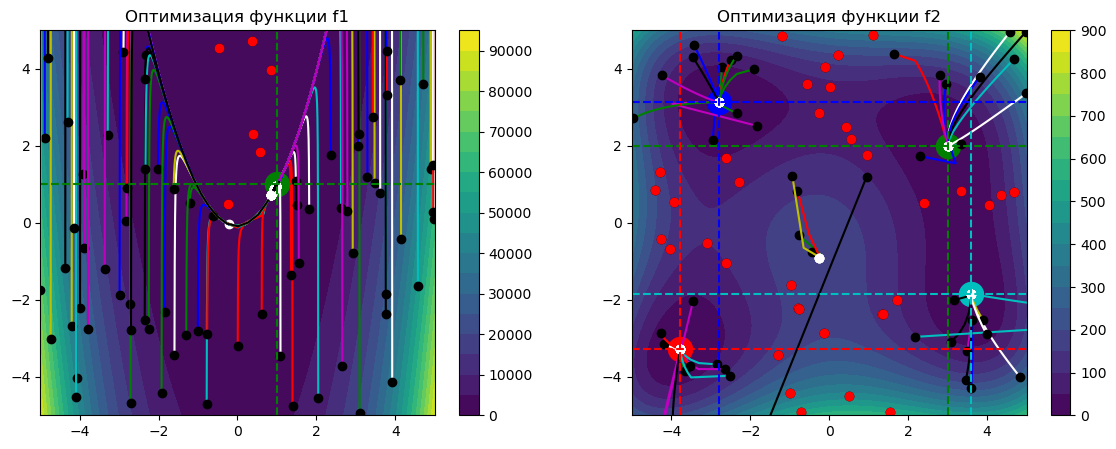

In [17]:
%%time

random.seed(42)

N_maxs = [1000, 100]
eps = 1e-4
mins = [
    [(1, 1)],
    [
        (3, 2),
        (-3.779, -3.283),
        (-2.805, 3.131),
        (3.584, -1.848),
    ],
]
verbose = True

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i, ax, f, hessian_f in zip(range(2), axs, [f1, f2], [hessian_f1, hessian_f2]):
    x1 = np.linspace(-5, 5, 1000)
    x2 = np.linspace(-5, 5, 1000)
    X, Y = np.meshgrid(x1, x2)
    Z = f(X, Y)

    pcm = ax.contourf(X, Y, Z, levels=20)
    fig.colorbar(pcm, ax=ax)
    ax.set_title(f'Оптимизация функции f{i+1}')
    
    iterations_array = []

    # function optimization (start from different points)
    for col in 10 * ['r', 'g', 'b', 'w', 'c', 'm', 'y', 'k']:
        x0 = (random.random() * 10 - 5, random.random() * 10 - 5)

        x_opt, x_trace, iterations, good = newton_optimize(f, hessian_f, *x0, eps, max_iters=N_maxs[i])
        iterations_array.append(iterations)
        
        ax.plot(*x_trace, f'{col}-')
        ax.plot(*x0, f'ko')
        ax.plot(*x_opt, f'{("w" if good else "r")}o')
    
    
    if verbose:
        for col, mp in zip(['g', 'r', 'b', 'c', 'm', 'y', 'k'], mins[i]):
            ax.axvline(x=mp[0], color=col, linestyle='--')
            ax.axhline(y=mp[1], color=col, linestyle='--')
            ax.scatter(*mp, c=col, s=300)

        min_it = min(iterations_array)
        mean_it = np.mean(iterations_array)
        max_it = max(iterations_array)
        print(f'Кол-во итераций (функция f{i+1}) (min, mean, max): {min_it, mean_it, max_it} ')

axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
None